### Setup

In [1]:
from neuron import h
from cell_inference.config import params, paths
import pandas as pd

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_AXON, index_col='id')
h.dt = params.DT

h.tstop = 200.

### Setup smiulation parameters

In [2]:
import json

# Biophysical parameters
filepath = "./cell_inference/resources/fit_parameters.json"
f = open(filepath)
biophys_param = json.load(f)
f.close()

In [3]:
loc_param = [0., 350., 80., 1, 1.0,   0.]  # position (x,y,z,alpha,h,phi)
geo_param = [8., 400., 1.25, .28, .28, 200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])

In [4]:
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes

sim = Simulation(geometry = geo_standard,
                 full_biophys = biophys_param,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE_AXON,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 gmax = [0.,0.05],
                 stim_param = {'start': 5.},
                 scale = 1.,
                 ncell = 2)

#### Add current injection

In [5]:
sim.cells[0].add_injection(sec_index=0, pulse=True, amp=-0.010, delay=50.0, dur=150.0)

#### Record axial current

In [6]:
from cell_inference.utils.currents.somaaxialcurrent import Soma_Axial_Current

axial_current = Soma_Axial_Current(sim.cells[1].soma,single_seg=True)

### Simulation results

In [7]:
sim.run_neuron_sim()
# lfp = sim.get_lfp().T
t = sim.t()
v = sim.v('all')

#### Membrane voltage

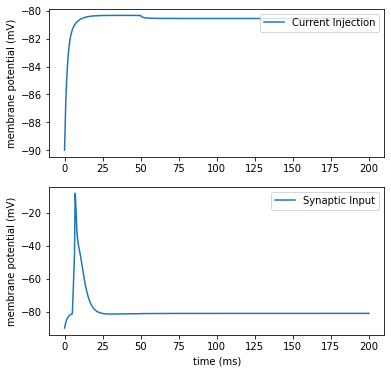

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(t,v[0],label='Current Injection')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t,v[1],label='Synaptic Input')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.show()

#### Calculate passive properties

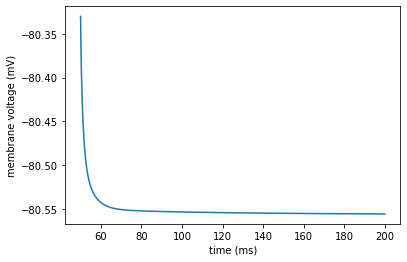

In [9]:
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

plt.figure()
Vrest, Rin, Tau = measure_passive_properties(v[0],t,sim.cells[0].injection[0].pp_obj,ax=plt.gca())

In [10]:
Vrest, Rin, Tau

(-80.33001182103993, 22.577414005812102, 1.7750000000004036)

#### Axial currents

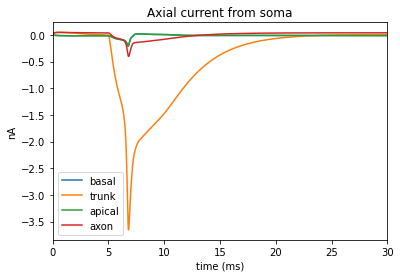

In [12]:
dend_types = axial_current.dend_type

plt.figure()
ac = axial_current.get_current()
for dend_type in dend_types:
    plt.plot(t,ac[dend_type].ravel(),label=dend_type)
plt.ylabel('nA')
plt.legend()
plt.title('Axial current from soma')
plt.xlabel('time (ms)')
plt.xlim([0,30])
plt.show()